# Process FFT Datasets Into Images

Here, we go through the classed functions for formatting the fft datasets into their image representations. We can:

- map data using the xyz coordinates using a PCA method
- map data using the inverse gain matrix transposed to map onto the parcellated 84 regions in MRI xyz space

These methods can be compared to determine the accuracy of encoding different types of structural information into the models.

In [4]:
import numpy as np
import os
import sys
import pandas as pd

sys.path.append('../')
from dnn.processing.format import formatfft
from dnn import processing
from dnn.processing.util import DataHandler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def main(fftdatadir, rawdatadir,  metadatadir, outputdatadir):
    formatter = formatfft.FormatFFT(fftdatadir, rawdatadir, metadatadir, outputdatadir)

    formatter.getdatafiles()
    formatter.formatdata()
    print('finished!')

In [5]:
patid = 'id001_ac'
patid = 'id001_bt'

# the main data directories that there is raw, meta, and output data
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'
rawdatadir = '/Volumes/ADAM LI/pydata/convertedtng/'
rawdatadir = os.path.join('/Volumes/ADAM LI/rawdata/tvbpipeline/', patid)
fftdatadir = '/Volumes/ADAM LI/pydata/output_fft/tngcenter/win500_step250/'
# fftdatadir = '/Volumes/ADAM LI/pydata/output_fft/tvbsim/full/'
outputdatadir = '/Volumes/ADAM LI/pydata/output_fft/asimages/regions/'

# confile = os.path.join(metadatadir, patid, 'connectivity.zip')
# gainmatfile = os.path.join(metadatadir, patid, 'gain_inv-square.txt')
# run conversion
# main(fftdatadir, rawdatadir, metadatadir, outputdatadir)

In [12]:
elecdir = os.path.join(rawdatadir, 'elec')
seegxyzfile = os.path.join(elecdir, 'seeg.txt')

seeg_pd = pd.read_csv(seegxyzfile, names=['x', 'y', 'z'], delim_whitespace=True)
display(seeg_pd.head())

seeg_xyz = seeg_pd.as_matrix(columns=None)

,x,y,z
TP'1,-17.36,9.14,-51.66
TP'2,-21.09,9.18,-50.91
TP'3,-24.58,8.97,-50.98
TP'4,-27.86,8.95,-50.34
TP'5,-31.25,9.18,-50.26


(161, 2)


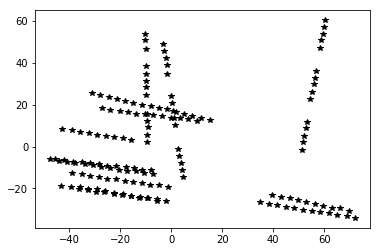

In [19]:
pca = PCA(n_components=2)
# tsne = TSNE(n_components=2)
# project xyz data
seeg_xyz = pca.fit_transform(seeg_xyz)
# seeg_xyz = tsne.fit_transform(seeg_xyz)

print(seeg_xyz.shape)
# sns.pointplot(x=seeg_xyz[:,0], y=seeg_xyz[:,1])
plt.plot(seeg_xyz[:,0], seeg_xyz[:,1], 'k*')

(161, 2)


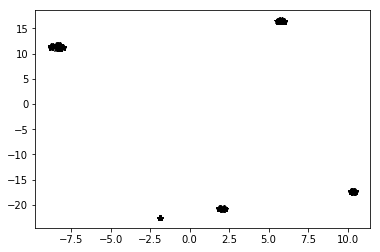

In [31]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2,  perplexity=35)
# project xyz data
# seeg_xyz = pca.fit_transform(seeg_xyz)
seeg_xyz = tsne.fit_transform(seeg_xyz)

print(seeg_xyz.shape)
# sns.pointplot(x=seeg_xyz[:,0], y=seeg_xyz[:,1])
plt.plot(seeg_xyz[:,0], seeg_xyz[:,1], 'k*')

# Check Processed Data By Visualization

Data should be processed into region mappings using the inverted gain matrix obtained from the dipole-dipole model in TVB for each patient.

In [29]:
import matplotlib
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    
    # initialize figure to draw on
    fig, ax = plt.subplots()
    ax.volume = volume
    
    # set index as the first axis
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index], cmap='jet',origin='lower')

    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j': # go to previous slice
        previous_slice(ax)
    elif event.key == 'k': # go to next slice
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    '''
    a helper function to remove keys that we want 
    to use wherever they may appear in this dictionary.
    '''
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

id001_ac_absence_fftmodel.npz
['image_tensor', 'metadata']
dict_keys(['chanlabels', 'seeg_xyz', 'reg_xyz', 'ylabels', 'samplerate', 'timepoints'])
(84, 5, 1799)


<IPython.core.display.Javascript object>


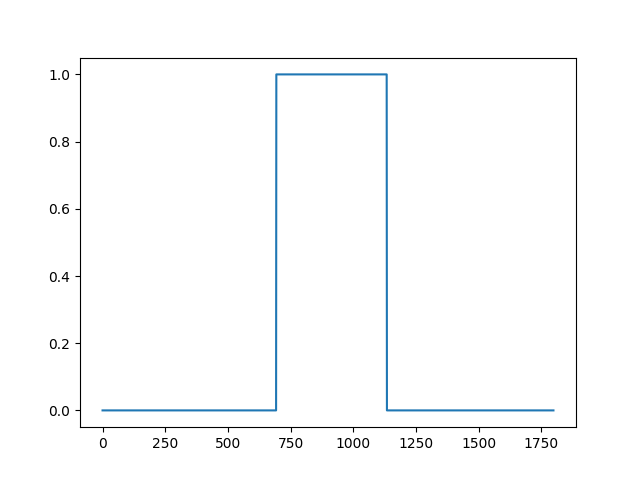

In [39]:
datafiles = os.listdir(os.path.join(outputdatadir, 'real'))

for datafile in datafiles:
    print(datafile)

    data = np.load(os.path.join(outputdatadir, 'real', datafile))
    
    image_tensor = data['image_tensor']
    metadata = data['metadata'].item()
    chanlabels = metadata['chanlabels']
    seeg_xyz = metadata['seeg_xyz']
    reg_xyz = metadata['reg_xyz']
    ylabels = metadata['ylabels']
    
    print(data.keys())
    print(metadata.keys())
    print(image_tensor.shape)
    
    plt.figure()
    plt.plot(ylabels)
    plt.show()
    break

(1799, 5, 7, 12)


<IPython.core.display.Javascript object>


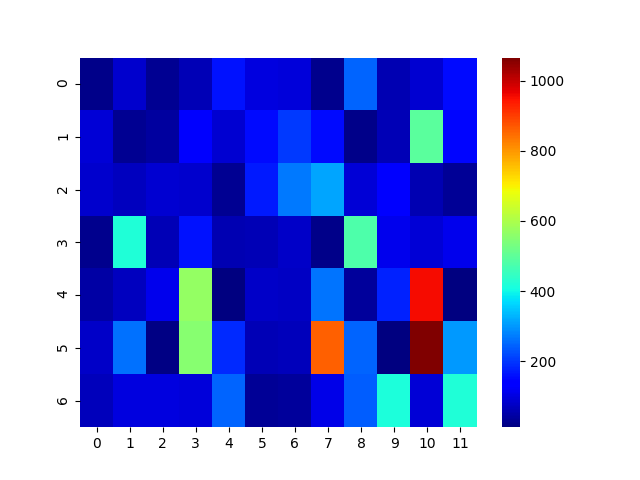

In [54]:
image = image_tensor.reshape(12,7,5,1799)
image = image.swapaxes(0,3)
image = image.swapaxes(1,2)
print(image.shape)

plt.figure()
sns.heatmap(image[80,3,...], cmap='jet')
plt.show()

(1799, 5, 7, 12)


<IPython.core.display.Javascript object>


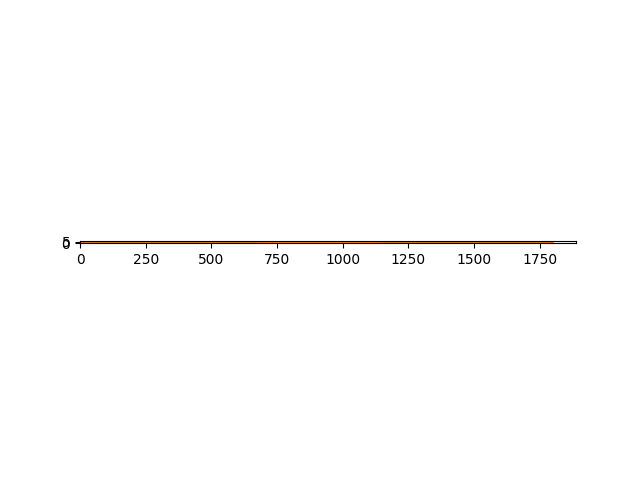

In [32]:
image = image_tensor.reshape(12,7,5,1799)
image = image.swapaxes(0,3)
image = image.swapaxes(1,2)
print(image.shape)
# fig, ax = plt.subplots()
# ax.imshow(image_tensor[0,0,:,:,:])
# fig.canvas.mpl_connect('key_press_event', process_key)
%matplotlib notebook
multi_slice_viewer(image[:,0,:,:])

# Process FFT Datasets Into Image Sequences

Use the PCA method and the gain matrix method into their corresponding image format.


In [37]:
# establish frequency bands
freqbands = {
        'dalpha':[0,15],
        'beta':[15,30],
        'gamma':[30,90],
        'high':[90,400],
    }
postprocessfft = processing.preprocessfft.PreProcess(freqbands=freqbands)

# directory where the fft computations are stored
expname = 'full' # change for different experiment datasets
fftdatadir = os.path.join('/Volumes/ADAM LI/pydata/output_fft/tvbsim/', expname)

# image to save the computed fft images into
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/output_fft/asimages/', 
                        expname)
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
    
# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(fftdatadir):
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))
print(len(datafiles))

116


In [38]:
# define the data handler 
datahandler = DataHandler()
pca = PCA(n_components=2)

for idx, datafile in enumerate(datafiles):
    print(idx)
    # perform file identification
    dirname = os.path.dirname(datafile)
    filename = path_leaf(datafile)
    fileid = filename.split('_fftmodel')[0]
    patient = '_'.join(fileid.split('_')[0:2])
    
    # extract data from the fft computed file
    fftdata = np.load(datafile)
    power = fftdata['power']
    freqs = fftdata['freqs']
    timepoints = fftdata['timepoints']
    metadata = fftdata['metadata'].item()
    chanlabels = metadata['chanlabels']
    seeg_xyz = metadata['seeg_xyz']
    onsettimes = np.array(metadata['onsettimes'])
    offsettimes = np.array(metadata['offsettimes'])
    samplerate = metadata['samplerate']
    
    # get rid of any nans
    if np.isnan(onsettimes).any():
        onsettimes = onsettimes[~np.isnan(onsettimes).astype(int)]
    if np.isnan(offsettimes).any():
        offsettimes = offsettimes[~np.isnan(offsettimes)]
    print(metadata.keys())
    
    # set power to get the absolute value
    power = np.abs(power)
    
    # postprocess fft into bins
    power = postprocessfft.binFrequencyValues(power, freqs)

    # project xyz data
    seeg_xyz = pca.fit_transform(seeg_xyz)
    
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(seeg_xyz, power, 
                            n_gridpoints=32, normalize=False, augment=False, 
                            pca=False, std_mult=0., edgeless=False)
    
    # compute ylabels    
    ylabels = datahandler.computelabels(onsettimes, offsettimes, timepoints)
    # instantiate metadata hash table
    metadata = dict()
    metadata['chanlabels'] = chanlabels
    metadata['seeg_xyz'] = seeg_xyz
    metadata['ylabels'] = ylabels
    metadata['samplerate'] = samplerate
    metadata['timepoints'] = timepoints
#     metadata['gainmat']
    
    # save image and meta data
    imagefilename = os.path.join(trainimagedir, filename.split('.npz')[0])

    print(power.shape)
    print(chanlabels)
    print(chanlabels.shape)
    print(power.shape)
    assert power.shape[0] == seeg_xyz.shape[0]
    assert power.shape[0] == len(chanlabels)
    print(image_tensor.shape)
    print(seeg_xyz.shape)
    print(power.shape)
    print('saved at ', imagefilename)
    break
    np.savez_compressed(imagefilename, image_tensor=image_tensor, metadata=metadata)

0
dict_keys(['chanlabels', 'gainmat', 'x0norm', 'pz', 'ez', 'seeg_xyz', 'regions_centers', 'regions', 'epiparams', 'offsettimes', 'seizoffsets', 'x0pz', 'onsettimes', 'pzindices', 'x0ez', 'patient', 'seizonsets', 'samplerate', 'ezindices', 'winsize', 'stepsize', 'mtbandwidth'])
(110, 126, 319)
[b"PM'1" b"PM'2" b"PM'3" b"PM'4" b"PM'5" b"PM'6" b"PM'7" b"PM'8" b"PM'9"
 b"PM'10" b"SA'1" b"SA'2" b"SA'3" b"SA'4" b"SA'5" b"SA'6" b"SA'7" b"SA'8"
 b"SA'9" b"SA'10" b"SC'1" b"SC'2" b"SC'3" b"SC'4" b"SC'5" b"SC'6" b"SC'7"
 b"SC'8" b"SC'9" b"SC'10" b"SC'11" b"SC'12" b"SC'13" b"SC'14" b"SC'15"
 b"PA'1" b"PA'2" b"PA'3" b"PA'4" b"PA'5" b"PA'6" b"PA'7" b"PA'8" b"PA'9"
 b"PA'10" b"CC'1" b"CC'2" b"CC'3" b"CC'4" b"CC'5" b"CC'6" b"CC'7" b"CC'8"
 b"CC'9" b"CC'10" b"CC'11" b"CC'12" b"CC'13" b"CC'14" b"CC'15" b"CP'1"
 b"CP'2" b"CP'3" b"CP'4" b"CP'5" b"CP'6" b"CP'7" b"CP'8" b"CP'9" b"CP'10"
 b"CP'11" b"CP'12" b"CP'13" b"CP'14" b"CP'15" b"PI'1" b"PI'2" b"PI'3"
 b"PI'4" b"PI'5" b"PI'6" b"PI'7" b"PI'8" b"PI'9" b"

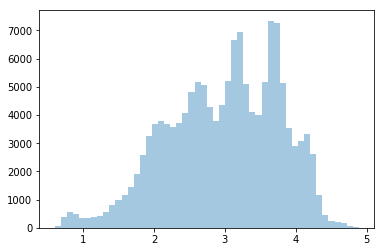

In [40]:
sns.distplot(power.ravel(), kde=False)